tigramite github repo: https://github.com/jakobrunge/tigramite/tree/master/tutorials

required python packages:

* python=3.7/3.8/3.9
* numpy==1.21.5
* scipy==1.8.0
* numba==0.55.1

# Environment setup


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Installing modules for graph generation
!pip install graphviz
!apt install libgraphviz-dev
!pip install pygraphviz
#Importing common packages
import os
import math
import glob
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.pyplot as plt
#Importing packages for graph generation
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
#Importing packages for Granger Causality
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

#Importing packages for PCMCI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#Restart runtime after successfully running this cell

!pip install dcor
!pip install matplotlib --upgrade
!pip install tigramite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 609 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 5.3 MB/s 
     |████████████████████████████████| 295 kB 49.1 MB/s 
     |████████████████████████████████| 965 kB 11.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 7.4 MB/s 
     |████████████████████████████████| 15.7 MB 46 kB/s 
     |████████████████████████████████| 41.6 MB 1.2 MB/s 
     |████████████████████████████████| 3.4 MB 31.0 MB/s 
     |████████████████████████████████| 34.5 MB 5.0 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


In [1]:
# Imports
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline     
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

/usr/local/lib/python3.8/dist-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/usr/local/lib/python3.8/dist-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/usr/local/lib/python3.8/dist-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/usr/local/lib/python3.8/dist-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/usr/local/lib/python3.8/dist-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))


# Load dataset

In [2]:
fp='/content/drive/My Drive/UMBC/Courses/2022_Fall/IS_800/IS 800 - group project/Data/Arctic Sea Ice/Arctic_domain_mean_1979_2021.csv'

In [3]:
sea_ice = pd.read_csv(fp)
sea_ice_features = sea_ice.iloc[:,1:] # remove date column
print(sea_ice_features.head)


<bound method NDFrame.head of        wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0      5.872050           0.786595  184.999071    1.417925  1.089897   
1      6.155597           0.756973  182.686318    1.368594  0.923499   
2      5.691054           0.777598  186.387764    1.197913  1.218984   
3      5.628824           0.819629  191.888081    1.405106  1.783778   
4      6.255928           0.869896  190.541890    1.305893  0.995828   
...         ...                ...         ...         ...       ...   
15579  5.386638           4.563584  305.197693  102.101318  2.559692   
15580  5.234190           4.366545  302.980530  102.355118  1.951954   
15581  4.675841           4.300599  302.045685   98.769402  1.618767   
15582  4.396615           4.272134  300.618896   99.093216  1.643894   
15583  4.430712           4.206679  298.726013   94.778908  1.605882   

       snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0      1.031549  273.379711  

In [4]:
# copy variable names from headlines to define dataframe
var_name = ['wind_10m','specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent']
features = pd.read_csv(fp,header=None, skiprows=1).iloc[:,1:]
np_features = features.to_numpy()

dataframe = pp.DataFrame(np_features, var_names = var_name)

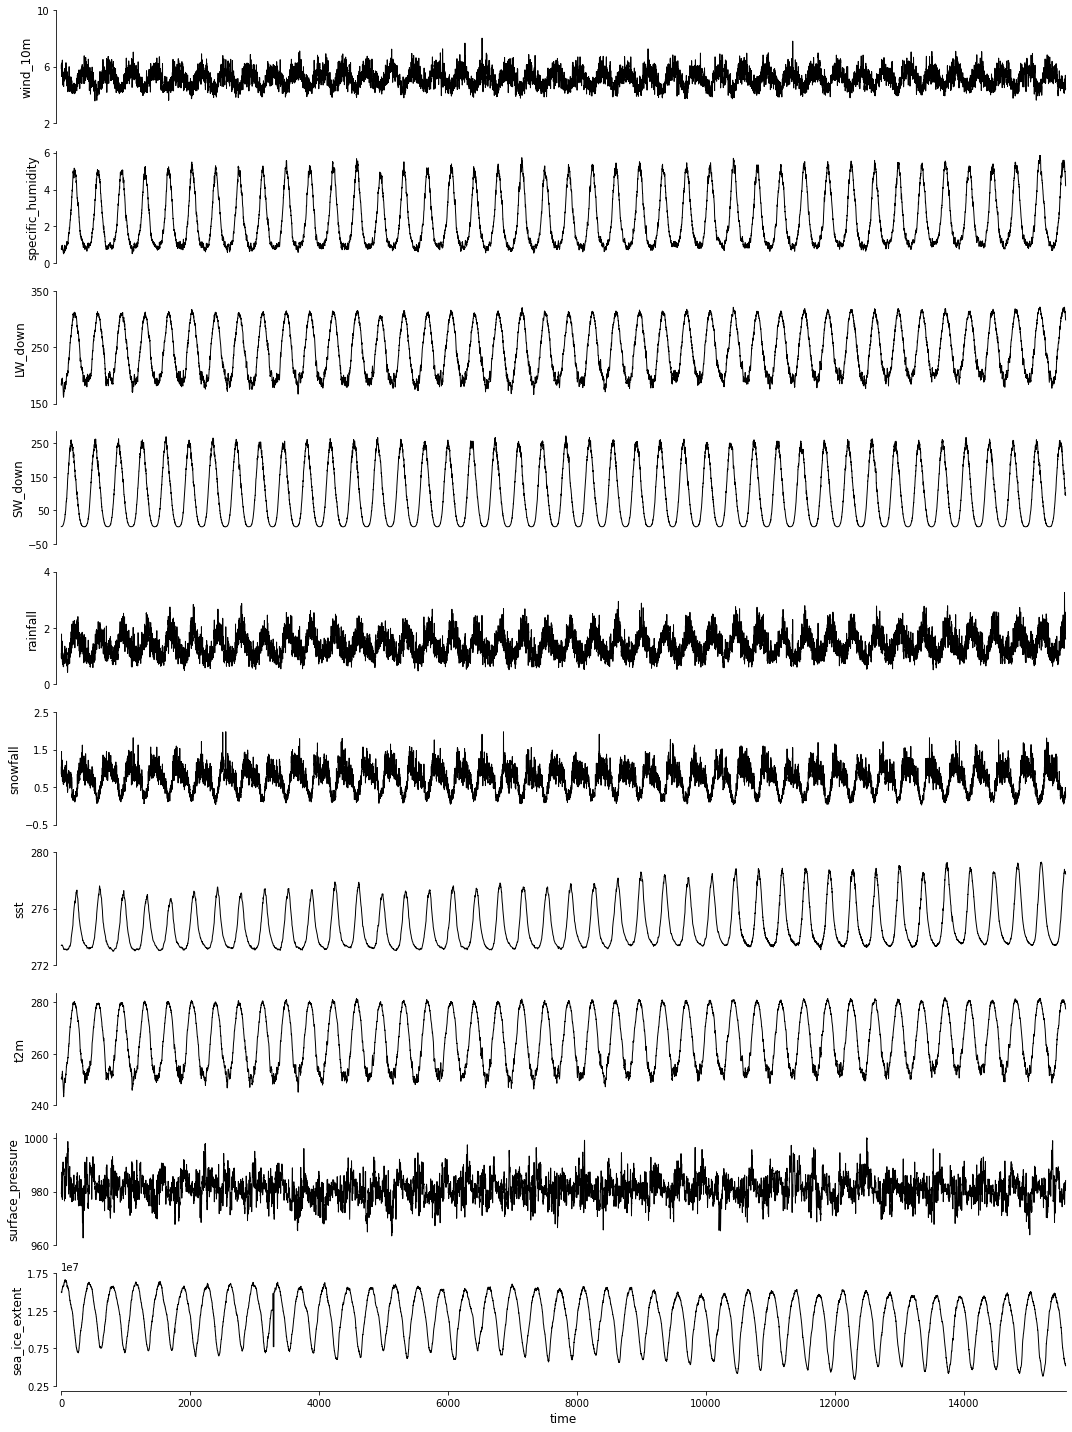

In [ ]:
tp.plot_timeseries(dataframe, figsize=(15,20));
plt.pause(15)
plt.show()


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 90


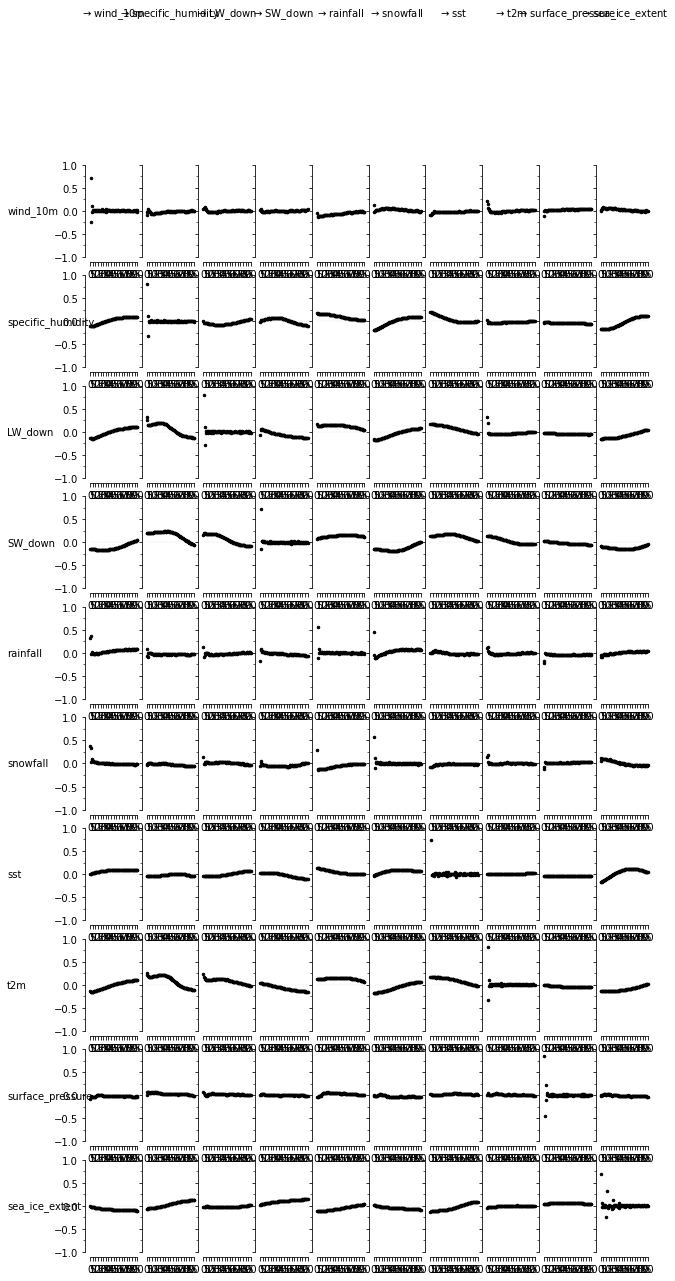

In [ ]:
# Obitain an idea which tau_max to choose
parcorr = ParCorr(significance = 'analytic')
# gpdctorch = GPDCtorch(significance = 'analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=1)
correlations = pcmci.run_bivci(tau_max=90, val_only=True)['val_matrix']

setup_args = {'var_names':var_name,
              'figsize':(10, 20),
              'x_base':5,
              'y_base':.5}
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args=setup_args)

# parcorr indepence check

## PCMCI

In [5]:
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance = 'analytic'), verbosity = 1)

tau_max = 90
pc_alpha = 0.01

results_pcmci = pcmci.run_pcmci(tau_max = tau_max, pc_alpha = pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 90
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable wind_10m has 9 link(s):
        (wind_10m -1): max_pval = 0.00000, min_val =  0.867
        (snowfall -1): max_pval = 0.00000, min_val =  0.218
        (wind_10m -2): max_pval = 0.00000, min_val = -0.172
        (snowfall -2): max_pval = 0.00000, min_val =  0.145
        (snowfall -3): max_pval = 0.00000, min_val =  0.068
        (rainfall -1): max_pval = 0.00017, min_val = -0.030
        (SW_down -40): max_pval = 0.00841, min_val =  0.021
        (specific_humidity -14): max_pval = 0.00897, min_val = -0.021
        (wind_10m -4): max_pval = 0.00991, min_val =  0.021

    Variable specific_humidity has 11 link(s):
        (specific_humidity -1): max_pval = 0.00000, min_val =  0.999
        (specific_humidity -2): max_pval = 0.00000, min_val = -0.274
 

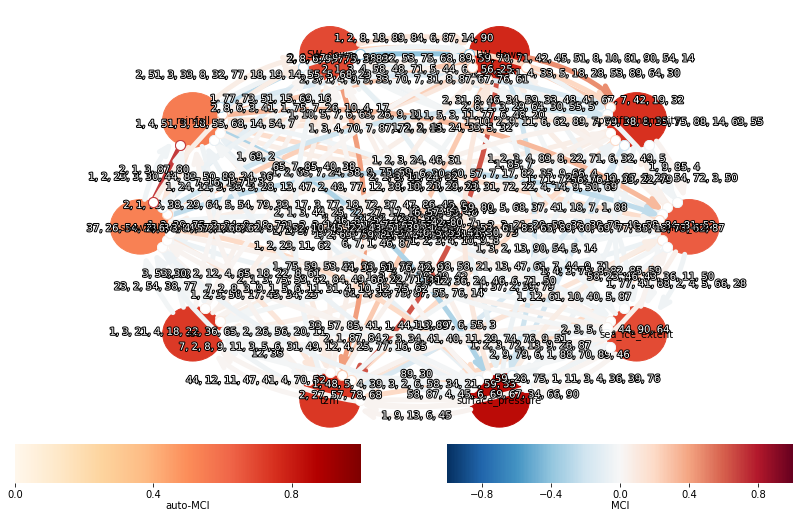

In [6]:
tp.plot_graph(graph=results_pcmci['graph'],
              val_matrix=results_pcmci['val_matrix'],
              var_names = var_name,
              figsize = (12,9))
plt.show()

In [7]:
results_plus = pcmci.run_pcmciplus(tau_max = tau_max, pc_alpha = pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 90
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable wind_10m has 9 link(s):
        (wind_10m -1): max_pval = 0.00000, min_val =  0.867
        (snowfall -1): max_pval = 0.00000, min_val =  0.218
        (wind_10m -2): max_pval = 0.00000, min_val = -0.172
        (snowfall -2): max_pval = 0.00000, min_val =  0.145
        (snowfall -3): max_pval = 0.00000, min_val =  0.068
        (rainfall -1): max_pval = 0.00017, min_val = -0.030
        (SW_down -40): max_pval = 0.00841, min_val =  0.021
        (specific_humidity -14): max_pval = 0.00897, min_val = -0.021
        (wind_10m -4): max_pval = 0.00991, min_val =  0.021

    Variable specific_humidity has 11 link(s):
        (specific_humidity -1): max_pval = 0.00000, min_val =  0.999
        (specific_humidity -2): max_pval = 0.00000, min_val = -0.274
 

## PCMCI_Plus

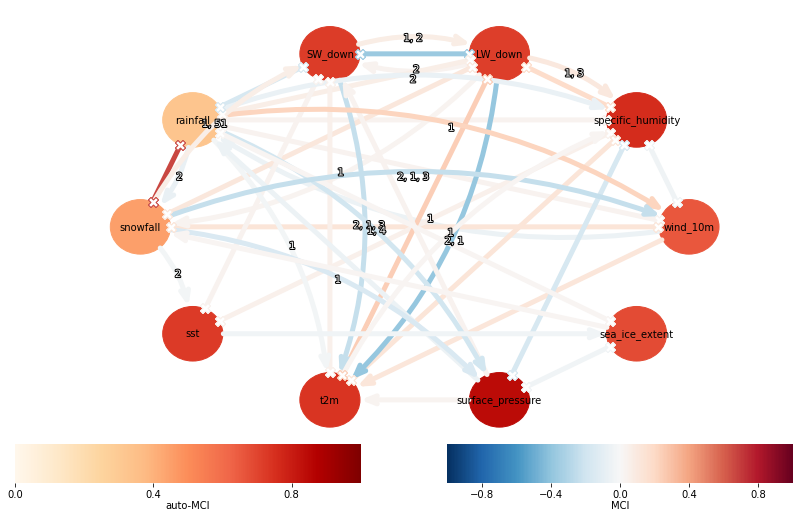

In [8]:
tp.plot_graph(graph=results_plus['graph'],
              val_matrix=results_plus['val_matrix'],
              var_names = var_name,
              figsize = (12,9))
plt.show()